# **Year 3 project - Optimising the stability of a catalyst**

**Data Loading + imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
initial_df = pd.read_csv(r'C:\Users\Fahim\Yr3-Project-1\Python import.csv')

**Data exploration**

In [2]:
#print(initial_df.head())
print(initial_df.columns)
#print(initial_df.describe())
print(initial_df.info())

Index(['Catalyst Materials', 'Family', 'Substrate',
       'Operating Conditions (T, pH, potential)', 'Valence state, A',
       'Valence state, B', 'Ionic radius A', 'Ionic radius B', 'ΔGOH*', 'ΔGO*',
       'ΔGOOH*', 'Adsorption strength', 'Stable hours/cycles',
       'Tafel Slope, mV per decade',
       'Overpotential at xx (nearby) current density vs RHE, V',
       'Reaction (HER, HRR, OER, ORR)'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1012 entries, 0 to 1011
Data columns (total 16 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Catalyst Materials                                      1012 non-null   object 
 1   Family                                                  964 non-null    object 
 2   Substrate                                               927 non-null    object 
 3   Operating Conditions (T, pH, pote

**Data cleaning**

In [3]:
def parse_Nan(dataset):
    parse_datatset = dataset.replace('-',0) 
    parse_datatset = parse_datatset.fillna(0)
    return parse_datatset

In [4]:
initial_df = parse_Nan(initial_df)
entropy_data = initial_df[["Catalyst Materials","ΔGOH*","ΔGO*","ΔGOOH*","Overpotential at xx (nearby) current density vs RHE, V"]]
columns_to_int = ["ΔGOH*","ΔGO*","ΔGOOH*","Overpotential at xx (nearby) current density vs RHE, V"]
entropy_data[columns_to_int] = entropy_data[columns_to_int].astype(float)
entropy_data['ΔGO*-ΔGOH*'] = entropy_data['ΔGO*'] - entropy_data['ΔGOH*']
print(entropy_data.describe())

             ΔGOH*         ΔGO*       ΔGOOH*  \
count  1012.000000  1012.000000  1012.000000   
mean      0.708162     2.163360     3.332609   
std       0.878306     1.750596     1.693789   
min      -2.840000    -2.960000     0.000000   
25%       0.000000     0.317500     3.000000   
50%       0.650000     2.235000     3.840000   
75%       1.350000     3.370000     4.460000   
max       2.930000     5.800000     5.840000   

       Overpotential at xx (nearby) current density vs RHE, V   ΔGO*-ΔGOH*  
count                                        1012.000000       1012.000000  
mean                                            1.192027          1.455198  
std                                             0.607958          0.996968  
min                                             0.000000         -0.700000  
25%                                             0.700000          0.720000  
50%                                             1.330000          1.530000  
75%                         

C:\Users\Fahim\AppData\Local\Temp\ipykernel_23360\1325211341.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entropy_data[columns_to_int] = entropy_data[columns_to_int].astype(float)
C:\Users\Fahim\AppData\Local\Temp\ipykernel_23360\1325211341.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entropy_data['ΔGO*-ΔGOH*'] = entropy_data['ΔGO*'] - entropy_data['ΔGOH*']


**Preparing first graph**

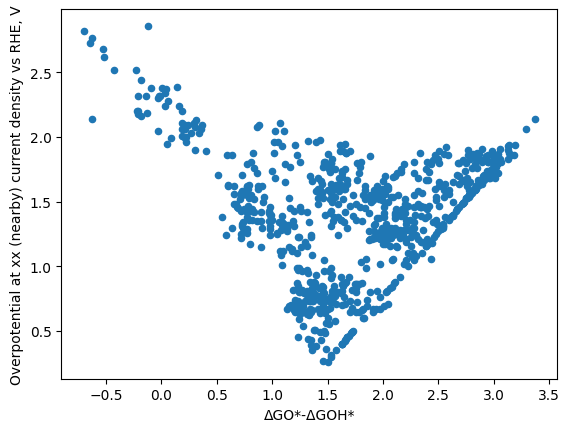

In [5]:
entropy_data = entropy_data.loc[entropy_data["ΔGO*-ΔGOH*"] != 0.0 ]
#print(entropy_data)
entropy_data.plot(x='ΔGO*-ΔGOH*', y = 'Overpotential at xx (nearby) current density vs RHE, V', kind='scatter')
plt.show()